This notebook provides example for multuple matching. Three multuple matching methods are provided: (1) Reference matching, (2) Sequential matching, and (3) Iterative matching.

Multiple activation matching can be performed by replacing the weight matching function with the activation matching function. The usage of activation matching is shown in matching.ipynb.

In [1]:
import sys
sys.path.append("..")

In [2]:
import torch
from source.utils.utils import load_model
from source.utils.data_funcs import load_data
from source.utils.weight_matching import weight_matching
from source.utils.connect import interpolate_multi_state_dicts, reset_bn_stats
from source.utils.logger import Logger
from torch.utils.data import DataLoader
from source.utils.train import validate
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

In [3]:
class config:
    model = 'cifar_vgg16_bn'
    dataset = 'cifar10'
    special_init = 'vgg_init' # 'vgg_init' (kaiming init) or None (uniform init)
    print_freq = 100
    data_dir = '../../Linear_Mode_Connectivity/data'

In [4]:
# necessary to create logger if using the train/validate/eval_line etc. functions
Logger.setup_logging()
logger = Logger()

trainset, testset = load_data(config.data_dir, config.dataset)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=256, shuffle=False)

trainset_noaug, _ = load_data(config.data_dir, config.dataset, no_random_aug=True)
trainloader_noaug = DataLoader(trainset_noaug, batch_size=128, shuffle=True)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.CrossEntropyLoss()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
res_dict = {'ref': {}, 'seq': {}, 'iter': {}}
reset = 'bn' in config.model or config.model == 'cifar_resnet20_4x'

Reference matching

In [6]:
num_model = 3
idx_s = np.arange(num_model)
path_s = [f'../../Linear_Mode_Connectivity/same_init_ex/{config.dataset}/{config.model}/diff_init/seed_10/model_1_160.pt',
            f'../../Linear_Mode_Connectivity/same_init_ex/{config.dataset}/{config.model}/diff_init/seed_10/model_2_160.pt',
            f'../../Linear_Mode_Connectivity/same_init_ex/{config.dataset}/{config.model}/diff_init/seed_20/model_1_160.pt']

np.random.shuffle(idx_s)
model_s = [load_model(config).to(device) for _ in range(num_model)]
sd_s = []
for i in range(num_model):
    sd_s.append(torch.load(path_s[idx_s[i]], map_location=device))
    model_s[i].load_state_dict(sd_s[i])

In [ ]:
model_wm_s = [load_model(config).to(device) for _ in range(num_model)]
sd_wm_s = [None] * num_model
sd_wm_s[0] = sd_s[0]

model_wm_s = [load_model(config).to(device) for _ in range(num_model)]
sd_wm_s = [None] * num_model
sd_wm_s[0] = sd_s[0]

for i in range(1, num_model):
    sd_wm, _ = weight_matching(config.model, sd_s[0], sd_s[i], device=device)
    sd_wm_s[i] = sd_wm
for i in range(num_model):
    model_wm_s[i].load_state_dict(sd_wm_s[i])

test_loss_wm_mid = []
test_acc_wm_mid = []
model_mid = load_model(config).to(device)
for i in range(1, num_model+1):
    sd_mid = interpolate_multi_state_dicts(sd_wm_s[:i], [1/i]*i)
    model_mid.load_state_dict(sd_mid)
    if reset:
        reset_bn_stats(model_mid, device, trainloader)
    test_loss, test_acc, _, _ = validate(testloader, model_mid, criterion, device, config)
    test_loss_wm_mid.append(test_loss)
    test_acc_wm_mid.append(test_acc)

In [8]:
res_dict['ref']['test_loss'] = deepcopy(test_loss_wm_mid)
res_dict['ref']['test_acc'] = deepcopy(test_acc_wm_mid)

Sequential matching

In [ ]:
np.random.shuffle(idx_s)
sd_s = []
for i in range(num_model):
    sd_s.append(torch.load(path_s[idx_s[i]], map_location=device))
    model_s[i].load_state_dict(sd_s[i])

model_wm_s = [load_model(config).to(device) for _ in range(num_model)]
sd_wm_s = [None] * num_model
sd_wm_s[0] = sd_s[0]


for i in range(1, num_model):
    sd_wm, _ = weight_matching(config.model, sd_wm_s[i-1], sd_s[i], device=device)
    sd_wm_s[i] = sd_wm
for i in range(num_model):
    model_wm_s[i].load_state_dict(sd_wm_s[i])

test_loss_wm_mid = []
test_acc_wm_mid = []
model_mid = load_model(config).to(device)
for i in range(1, num_model+1):
    sd_mid = interpolate_multi_state_dicts(sd_wm_s[:i], [1/i]*i)
    model_mid.load_state_dict(sd_mid)
    if reset:
        reset_bn_stats(model_mid, device, trainloader)
    test_loss, test_acc, _, _ = validate(testloader, model_mid, criterion, device, config)
    test_loss_wm_mid.append(test_loss)
    test_acc_wm_mid.append(test_acc)

In [17]:
res_dict['seq']['test_loss'] = deepcopy(test_loss_wm_mid)
res_dict['seq']['test_acc'] = deepcopy(test_acc_wm_mid)

Iterative matching

In [10]:
def check_identity_perm(perm: dict):
    for k, v in perm.items():
        identity = torch.arange(v.shape[0])
        if not torch.all(torch.eq(v.cpu(), identity)):
            return False
    return True

In [11]:
np.random.shuffle(idx_s)
sd_s = []
for i in range(num_model):
    sd_s.append(torch.load(path_s[idx_s[i]], map_location=device))
    model_s[i].load_state_dict(sd_s[i])

In [ ]:
test_loss_wm_mid = []
test_acc_wm_mid = []
for n in range(1, num_model+1):
    sd_wm_s = [sd_s[i] for i in range(n)]
    num_iters = 0
    if n != 1:
        while True:
            flag = True
            random_order = torch.randperm(n)
            for i in random_order:
                sd_rest = [sd_wm_s[j] for j in range(n) if j != i]
                sd_ref = interpolate_multi_state_dicts(sd_rest, [1/(n-1)]*(n-1))
                sd_wm, perm = weight_matching(config.model, sd_ref, sd_wm_s[i], device=device, return_perm=True)
                return_identity = check_identity_perm(perm)
                flag = flag and return_identity
                sd_wm_s[i] = sd_wm
            if flag:
                break
            num_iters += 1

    model_mid = load_model(config).to(device)
    sd_mid = interpolate_multi_state_dicts(sd_wm_s[:n], [1/n]*n)
    model_mid.load_state_dict(sd_mid)
    if reset:
        reset_bn_stats(model_mid, device, trainloader)
    test_loss, test_acc, _, _ = validate(testloader, model_mid, criterion, device, config)
    test_loss_wm_mid.append(test_loss)
    test_acc_wm_mid.append(test_acc)

In [13]:
res_dict['iter']['test_loss'] = deepcopy(test_loss_wm_mid)
res_dict['iter']['test_acc'] = deepcopy(test_acc_wm_mid)

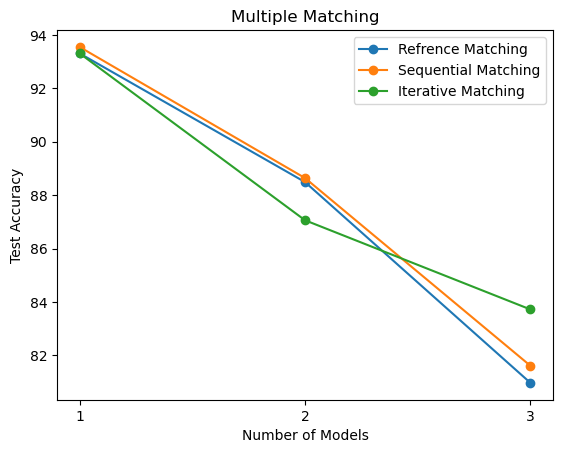

In [20]:
x_axis = list(range(1, num_model+1))

plt.plot(x_axis, res_dict['ref']['test_acc'], label='Refrence Matching', marker='o')
plt.plot(x_axis, res_dict['seq']['test_acc'], label='Sequential Matching', marker='o')
plt.plot(x_axis, res_dict['iter']['test_acc'], label='Iterative Matching', marker='o')

plt.title('Multiple Matching')
plt.xlabel('Number of Models')
plt.ylabel('Test Accuracy')
plt.xticks(x_axis)
plt.legend()